---

## Movie_Rating_Analysis



#### Data Manager

In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3

import warnings
warnings.filterwarnings('ignore')
import datetime

import re
import sentiments_nrc
from sentiments_nrc import SENTIMENTS
from sentiments_nrc import EMOTIONS

import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [24]:
reviews = pd.read_csv('../data/reviews.csv')
movies = pd.read_csv("../data/movies.dat", delimiter='\t')

In [25]:
### pre data cleaning for reviews data
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]
reviews['review_date']=pd.to_datetime(reviews['review_date']).dt.date
reviews=reviews.drop(['link'], axis=1)

In [26]:
### pre data cleaning for movies data
movies= movies.drop(['imdbPictureURL','spanishTitle','rtPictureURL'], axis=1)
# drop movies with unknow or non-numeric values 
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(pd.to_numeric, errors='drop')
movies['rtAllCriticsNumReviews'] = movies['rtAllCriticsNumReviews'].apply(pd.to_numeric, errors = 'drop')
movies['rtAudienceRating'] = movies['rtAudienceRating'].apply(pd.to_numeric, errors= 'drop')

In [27]:
reviews.head(2)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy Story
1,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy Story


In [28]:
movies.head(2)

,id,title,imdbID,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore
0,1,Toy story,114709,1995,toy_story,9.0,73.0,73,0,100,8.5,17,17,0,100,3.7,102338,81
1,2,Jumanji,113497,1995,1068044-jumanji,5.6,28.0,13,15,46,5.8,5,2,3,40,3.2,44587,61


In [29]:
sub_movies=movies[['title', 'imdbID', 'year', 'rtID','rtAllCriticsRating','rtAllCriticsNumReviews','rtAudienceNumRatings', 'rtAudienceScore']]

In [30]:
sub_movies.head(1)

,title,imdbID,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAudienceNumRatings,rtAudienceScore
0,Toy story,114709,1995,toy_story,9.0,73.0,102338,81


#### Visualization Manager I 

Please input the year range that you are interested in: 
2006
2009


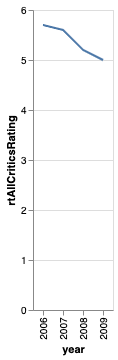

In [31]:
#### interactive one: draw the trendline of the median rating given a time interval 

def draw_trend_line_median_year(sub_movies):
    
    print('Please input the year range that you are interested in: ')
    

    start_year = int(input())
    end_year = int(input())
    
    year_median = sub_movies.groupby('year')['rtAllCriticsRating'].median().reset_index()
    year_show = year_median[year_median['year'] >= start_year]
    year_show = year_show[year_median['year'] <= end_year]
    
    
    selection = alt.selection_interval(bind='scales')

    chart = alt.Chart(year_show).mark_line().encode(
    x='year:N',
    y='rtAllCriticsRating:Q',
    tooltip='year:N').add_selection(selection)
    
    chart.save('chart.html')
    return chart
    

    
draw_trend_line_median_year(sub_movies)

In [32]:
def top5_critic_per_year(reviews,year):
    
    reviews['review_date'] = pd.to_datetime(reviews['review_date'])
    reviews['year'] = reviews['review_date'].dt.year
    Group_Aggregation = reviews[['critic', 'publication', 
                       'year', 'quote']].groupby(['critic','year']).agg({ 
                         'quote': ['count']}).reset_index()
    Group_Aggregation = Group_Aggregation[(Group_Aggregation['year'] == year)]
    Top_five = Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:5].reset_index(drop =True)
    
    print(Group_Aggregation)
    
    return Top_five.reset_index()



In [33]:
year = 1994

reviews['review_date'] = pd.to_datetime(reviews['review_date'])
reviews['year'] = reviews['review_date'].dt.year
Group_Aggregation = reviews[['critic', 'publication', 
                   'year', 'quote']].groupby(['critic','year']).agg({ 
                     'quote': ['count']}).reset_index()
Group_Aggregation = Group_Aggregation[(Group_Aggregation['year'] == year)]
Top_five = Group_Aggregation.sort_values(by=[('quote','count')], ascending = False)[:5].reset_index(drop =True)

print(Group_Aggregation)

                critic  year quote
                             count
930   Lisa Schwarzbaum  1994     4
1115   Owen Gleiberman  1994     7


In [34]:
top_critics =list( top5_critic_per_year(reviews,1994)['critic'])
# top_critics['critic']
# list(top_critics['critic'])
top_critics

                critic  year quote
                             count
930   Lisa Schwarzbaum  1994     4
1115   Owen Gleiberman  1994     7


['Owen Gleiberman', 'Lisa Schwarzbaum']

#### Visualization Manager II

In [35]:
#### interactive 2: sentiment analysis  for reviews of per critic 

### global variables 
movies_sub=movies[['title','imdbID']]
movie_review=reviews.merge(movies_sub, left_on='imdb', right_on='imdbID', how='inner')
movie_review=movie_review[['critic','publication','quote','review_date','title_x','imdb']]
EMOTIONS = ['positive', 'negative', 'anger', 
            'anticipation', 'disgust', 'fear', 
            'joy', 'sadness', 'surprise', 'trust']

# support function 1
def words_with_specific_emotion(list_of_split_words,emotion):
    '''Produce a list that include the words that contain a specific emotion
       Parameters: list_of_split_words (String): A list with split words 
                   emotion(string): the emotion words in EMOTIONS list
       Returns: list: the words in the string with one certain kind of emotion'''
    Look_Up=[SENTIMENTS.get(word) for word in list_of_split_words] #get the emotion list of every word in the list 
    Combine=list(zip(list_of_split_words,Look_Up)) # zip the emotion list with word in one list 
    Words_With_Specific_Emotion=[line[0] for line in Combine if line[1] is not None and line[1].get(emotion)==1 ]
    return Words_With_Specific_Emotion #find the words in a specific emotion

# support function 2
def words_list_for_each_emotion(Split_Test_String):
    '''Produce a disctionary with emotion words as keys and words list having that emotion as values
       Parameters: Split_Test_String (String): A list with split words
       Returns: list-the  most common words in the input list'''
    matching_words=[words_with_specific_emotion(Split_Test_String,emotion) for emotion in EMOTIONS]
    distinct_matching=[i for i in matching_words]
    return {emotion:matching_word for (emotion,matching_word) in zip(EMOTIONS,distinct_matching)}

# support function 3 
def get_common_words_list(wordlist):
    '''Produce a list with the most common words of the input list
       Parameters: wordlist (string): 
       Returns: dict: the key-values pairs of emotions word and its corresponding words in the string'''
    wordfreq=list(zip(wordlist,[wordlist.count(w) for w in wordlist]))
    wordfreq_sort=list(set(sorted(wordfreq,key=lambda freq: freq[1], reverse=True)))
    new_word_freq_sort=sorted(wordfreq_sort,key=lambda freq: freq[1], reverse=True)
    return [i[0] for i in new_word_freq_sort]


In [36]:
## main analysis function 
## I will wrap latter 
quote = pd.DataFrame()
for name in top_critics:
    critic_quote=movie_review[['critic','quote']]
    sub_quote = critic_quote[critic_quote['critic'] == name]
#     print(len(sub_quote))
    quote = quote.append(sub_quote,ignore_index=True)
    quote = quote.groupby('critic')['quote'].apply(' '.join).reset_index()
    
print(quote)
    
    
def analyze_quote(quote,top_critics):
    
#     criticname = input("Please enter the Critic that you are interested: ")
#     critic_quote=movie_review[['critic','quote']]
    res = pd.DataFrame()
    for name in top_critics:
        content = quote[quote['critic'] == name]['quote'].values[0]
#         content=quote.groupby('critic')['quote'].apply(' '.join).reset_index()['quote']
        Split_String=re.split(r'\W+',content) 
        lower_words=[word.lower() for word in Split_String] 
        length_filtered=[word for word in lower_words if len(word)>1]
    
    ### calculate total number or words
        Total_Words=len(length_filtered)
        Words_List_for_Each_Emotion=words_list_for_each_emotion(length_filtered)
    
        result_list=[]
        for i in EMOTIONS:
            result={}
            example_words=[get_common_words_list(value)[:3] for key,value in Words_List_for_Each_Emotion.items() if key==i]
            result['EMOTION']=i
            result['PERCENT']= len(Words_List_for_Each_Emotion[i])/Total_Words
            result['EXAMPLE WORDS']=example_words[0]
            result['name'] = name
            result_list.append(result)
            result=sorted(result_list,key=lambda k:k['PERCENT'],reverse=True)
            result = pd.DataFrame(result)
            res = res.append(result)
    

    return res

             critic                                              quote
0  Lisa Schwarzbaum  Australian director Chris Noonan and producer ...
1   Owen Gleiberman  Heat is an ''epic'' that feels like a stunt. I...


In [15]:
result= analyze_quote(quote,top_critics)
result.head()

,EMOTION,EXAMPLE WORDS,PERCENT,name
0,positive,"[don, director, action]",0.070557,Owen Gleiberman
0,positive,"[don, director, action]",0.070557,Owen Gleiberman
1,negative,"[pop, horror, lost]",0.051254,Owen Gleiberman
0,positive,"[don, director, action]",0.070557,Owen Gleiberman
1,negative,"[pop, horror, lost]",0.051254,Owen Gleiberman


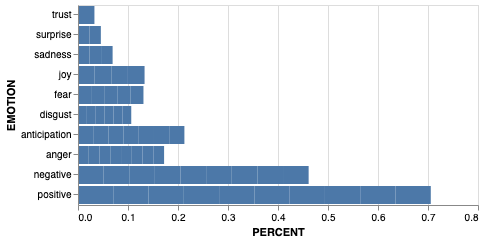

In [16]:
input_dropdown = alt.binding_select(options= top_critics)
selection = alt.selection_single(fields=['name'], bind=input_dropdown, name='Critic of ')
color = alt.condition(selection,
                    alt.Color('critic:N', legend=None),
                    alt.value('lightgray'))
alt.Chart(result).mark_bar().encode(
     x='PERCENT:Q',
     y=alt.Y(
        'EMOTION:N',
        sort=alt.EncodingSortField(field='PERCENT', op='count', order='ascending')
        ),
    color=color,
    tooltip='PERCENT:Q'
    ).add_selection(
    selection
)


In [17]:

# ## main analysis function 
# def analyze_quote(movie_review,criticname):
    
# #     criticname = input("Please enter the Critic that you are interested: ")
#     critic_quote=movie_review[['critic','quote']]
#     quote = critic_quote[critic_quote['critic'] == criticname[0]]
 
#     for name in criticname[1:]:
#         sub_quote = critic_quote[critic_quote['critic'] == name]
#         quote.append(sub_quote,ignore_index=True)
    
# #     print
#     #### cominbine quotes into one row 
#     content=quote.groupby('critic')['quote'].apply(' '.join).reset_index()['quote']
#     Split_String=re.split(r'\W+',content[0]) 
#     lower_words=[word.lower() for word in Split_String] 
#     length_filtered=[word for word in lower_words if len(word)>1]
    
#     ### calculate total number or words
#     Total_Words=len(length_filtered)
#     Words_List_for_Each_Emotion=words_list_for_each_emotion(length_filtered)
    
#     result_list=[]
#     for i in EMOTIONS:
#         result={}
#         example_words=[get_common_words_list(value)[:3] for key,value in Words_List_for_Each_Emotion.items() if key==i]
#         result['EMOTION']=i
#         result['PERCENT']= len(Words_List_for_Each_Emotion[i])/Total_Words
#         result['EXAMPLE WORDS']=example_words[0]
#         result_list.append(result)
#     result=sorted(result_list,key=lambda k:k['PERCENT'],reverse=True)
    
#     return pd.DataFrame(result)
# #     ### show the result in a table 
#     print("{0:<14} {1:<11} {2:35}".format('EMOTION','%WORDS','EXAMPLE WORDS'))
#     for line in result:
#         emotion=line['EMOTION']
#         words_percent=line['% WORDS']
#         format_words_percent='{:.2%}'.format(words_percent)
#         example_words=line['EXAMPLE WORDS']
#         top_example_words=','.join(example_words)
#         print("{0:<14} {1:<11} {2:35} ".format(emotion,format_words_percent,top_example_words))



In [18]:
### just for one year 

In [19]:
# result = analyze_quote(movie_review,'Jonathan Rosenbaum')

In [20]:
# alt.Chart(result).mark_bar().encode(
#      x='PERCENT:Q',
#      y=alt.Y(
#         'EMOTION:N',
#         sort=alt.EncodingSortField(field='PERCENT', op='count', order='ascending')
#         ),
#     color='EMOTION:N',
#     tooltip='PERCENT:Q'
#     )


## Potential Analysis 

### Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

In [21]:
reviewer_reviews=pd.DataFrame(reviews.groupby(['critic']).count().reset_index().sort_values('fresh'))

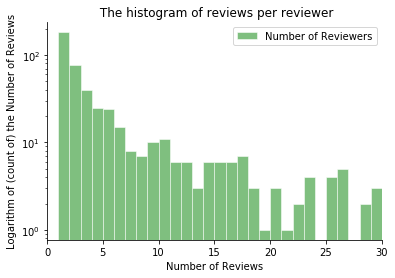

In [22]:
# enter your code here  
%matplotlib inline  
import matplotlib.pyplot as plt 
reviewer_reviews=pd.DataFrame(reviews.groupby('critic').count())
reviewer_reviews.reset_index(level=0, inplace=True)
fig, ax = plt.subplots()
plt.xlim([0, 30])
plt.yscale('log', nonposy='clip')
ax.hist(reviewer_reviews.quote, range=[0,30],bins=30,color=['green'],edgecolor = 'white',alpha=0.5)
plt.ylabel('Logarithm of (count of) the Number of Reviews') # add labels 
plt.xlabel('Number of Reviews')
plt.title(' The histogram of reviews per reviewer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(['Number of Reviewers'])
plt.show()